In [1]:
import pennylane as qml
from pennylane import numpy as np
from braket.aws import AwsDevice

from typing import List

import data_loader as dl

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import math

In [2]:
def inspect_classification_boundaries(
    variational_classifier, 
    params,
    plot_range: float,
    train_coordinates = None,
    train_labels = None,
    grid_size: int = 30,
):
    assert grid_size % 2 == 0, "Please input an even grid_size"
    
    x_range = [2 * plot_range * j / grid_size for j in range(-grid_size // 2, grid_size // 2 + 1, 1)]
    y_range = x_range
    grid_data = np.array([[j, k] for j in x_range for k in y_range])
    predictions = [variational_classifier_linear(params, f) for f in grid_data.reshape(-1, 1, 2)]
    pred_labels = 1 * (np.array(predictions) > 0.5)
    #plt.scatter(x=grid_data[:,0], y=grid_data[:,1], c=pred_labels)
    #plt.show()
    if (train_coordinates is not None) and (train_labels is not None):
        plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
    plt.contourf(x_range, y_range, pred_labels.reshape(grid_size + 1, grid_size + 1).T, levels=[-0.1, 0.5, 1.1], alpha=0.4)
    plt.show()

In [3]:
n_wires = 2
local_simulator = qml.device(
    "braket.local.qubit", 
    wires=n_wires,
    shots=256,
)

In [4]:
@qml.qnode(local_simulator)
def circuit(params, features):
    wires = range(n_wires)
    initial_state = np.zeros(n_wires)
    qml.BasisState(initial_state, wires=wires)
    qml.templates.BasicEntanglerLayers(features, wires=wires)
    #qml.templates.AngleEmbedding(features[0], wires, rotation='X')
    qml.templates.StronglyEntanglingLayers(params, wires)
    
    return qml.expval(qml.PauliX(0))

In [5]:
def variational_classifier_sigmoid(params, features):
    meas = circuit(params, features)
    sigmoid = 1 / (1 + np.exp(-5 * meas))
    return sigmoid

def variational_classifier_linear(params, features):
    meas = circuit(params, features)
    rescaled = (meas + 1) / 2
    return rescaled

def logloss(predictions, labels):
    loss = 0
    for p, lab in zip(predictions, labels):
        loss += - lab * np.log(p) - (1 - lab) * np.log(1 - p) 
    return loss / len(labels)

def squareloss(predictions, labels):
    loss = 0
    for p, lab in zip(predictions, labels):
        loss += (p - lab)**2 
    return loss / len(labels)

In [6]:
def logloss_cost(params, features, labels):
    predictions = [variational_classifier_sigmoid(params, f) for f in features]
    return logloss(predictions, labels)

def squareloss_cost(params, features, labels):
    predictions = [variational_classifier_linear(params, f) for f in features]
    return squareloss(predictions, labels)

In [7]:
n_variational_layers = 3
np.random.seed(1967)

initial_params = qml.init.strong_ent_layers_normal(n_variational_layers, n_wires)

In [8]:
n_components = n_wires
train_df, test_df = dl.load_train_test_pca(n_components)

max_value = np.max(abs(train_df.values))
plot_range = 3

train_df.iloc[:,:-1] = train_df.iloc[:,:-1] * plot_range / max_value
test_df.iloc[:,:-1] = test_df.iloc[:,:-1] * plot_range / max_value

train_coordinates = train_df.iloc[:,:-1].values.reshape(-1, 1, n_components)
train_labels = train_df.label
test_coordinates = test_df.iloc[:,:-1].values.reshape(-1, 1, n_components)
test_labels = test_df.label

In [146]:
train_df.describe()

,pca_1,pca_2,label
count,3.048000e+03,3.048000e+03,3048.000000
mean,5.827942e-18,-1.398706e-17,0.433071
std,6.437732e-01,6.437732e-01,0.495582
min,-1.684310e+00,-2.090419e+00,0.000000
25%,-5.052557e-01,-4.369367e-01,0.000000
50%,-1.015354e-01,-1.660771e-02,0.000000
75%,5.313561e-01,4.241519e-01,1.000000
max,1.910219e+00,3.000000e+00,1.000000


In [150]:
n_variational_layers = 3
np.random.seed(1967)
initial_params = qml.init.strong_ent_layers_normal(n_variational_layers, n_wires)

In [ ]:
opt = qml.NesterovMomentumOptimizer()

In [ ]:
opt.ste

Step: 0, Cost:  0.25620086669921877


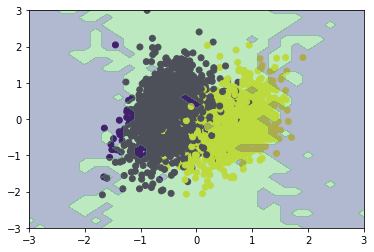

Step: 1, Cost:  0.24746978759765625
Step: 2, Cost:  0.259068603515625
Step: 3, Cost:  0.2579034423828125
Step: 4, Cost:  0.27234954833984376
Step: 5, Cost:  0.25644012451171877
Step: 6, Cost:  0.241754150390625
Step: 7, Cost:  0.2510797119140625
Step: 8, Cost:  0.24622772216796876
Step: 9, Cost:  0.24628143310546874
Step: 10, Cost:  0.237362060546875


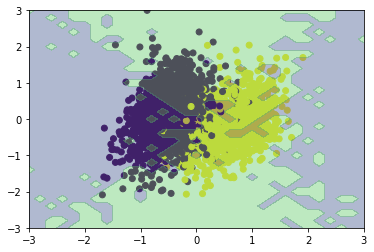

Step: 11, Cost:  0.23897705078125
Step: 12, Cost:  0.23253997802734375
Step: 13, Cost:  0.23793487548828124
Step: 14, Cost:  0.2300152587890625
Step: 15, Cost:  0.231893310546875
Step: 16, Cost:  0.23014892578125
Step: 17, Cost:  0.22679351806640624
Step: 18, Cost:  0.22996856689453124
Step: 19, Cost:  0.22134765625
Step: 20, Cost:  0.221666259765625


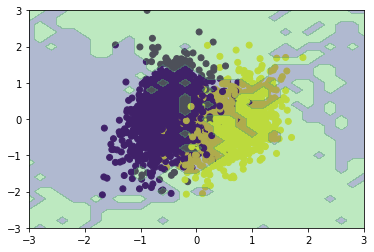

Step: 21, Cost:  0.20872955322265624
Step: 22, Cost:  0.213900146484375
Step: 23, Cost:  0.219432373046875
Step: 24, Cost:  0.20790924072265626
Step: 25, Cost:  0.2059423828125
Step: 26, Cost:  0.20083343505859375
Step: 27, Cost:  0.1978851318359375
Step: 28, Cost:  0.1894219970703125
Step: 29, Cost:  0.20659454345703124
Step: 30, Cost:  0.18726898193359376


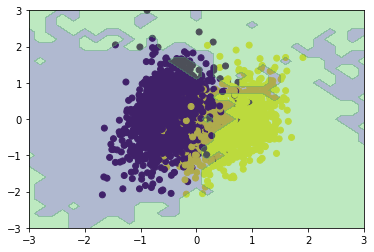

Step: 31, Cost:  0.1943133544921875
Step: 32, Cost:  0.18745941162109375
Step: 33, Cost:  0.1980828857421875
Step: 34, Cost:  0.19306915283203124
Step: 35, Cost:  0.1909271240234375
Step: 36, Cost:  0.17969818115234376
Step: 37, Cost:  0.174146728515625
Step: 38, Cost:  0.1962139892578125
Step: 39, Cost:  0.1610015869140625
Step: 40, Cost:  0.1740350341796875


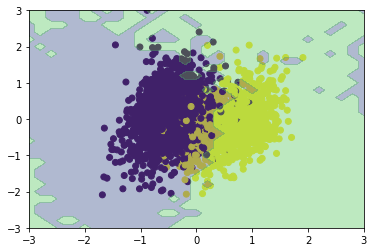

Step: 41, Cost:  0.171732177734375
Step: 42, Cost:  0.17506256103515624
Step: 43, Cost:  0.16297119140625
Step: 44, Cost:  0.158355712890625
Step: 45, Cost:  0.16479400634765626
Step: 46, Cost:  0.1746514892578125
Step: 47, Cost:  0.14951202392578125
Step: 48, Cost:  0.16336395263671874
Step: 49, Cost:  0.14851776123046875
Step: 50, Cost:  0.14356719970703125


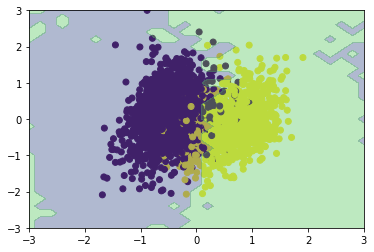

Step: 51, Cost:  0.16477020263671874
Step: 52, Cost:  0.1452587890625
Step: 53, Cost:  0.15571624755859376
Step: 54, Cost:  0.12919708251953124
Step: 55, Cost:  0.13326690673828126
Step: 56, Cost:  0.12913330078125
Step: 57, Cost:  0.14568572998046875
Step: 58, Cost:  0.12236846923828125
Step: 59, Cost:  0.13453216552734376
Step: 60, Cost:  0.12601409912109374


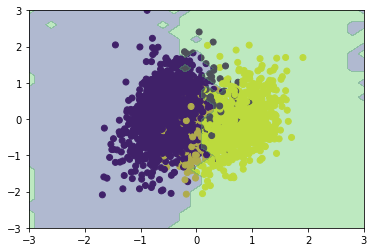

Step: 61, Cost:  0.1083050537109375
Step: 62, Cost:  0.12065704345703125
Step: 63, Cost:  0.1325177001953125
Step: 64, Cost:  0.11433624267578125
Step: 65, Cost:  0.13607086181640626
Step: 66, Cost:  0.13338653564453126
Step: 67, Cost:  0.11754486083984375
Step: 68, Cost:  0.123428955078125
Step: 69, Cost:  0.1424554443359375
Step: 70, Cost:  0.11650543212890625


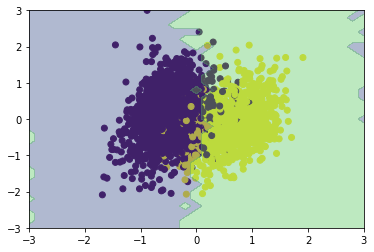

Step: 71, Cost:  0.12600555419921874
Step: 72, Cost:  0.112779541015625
Step: 73, Cost:  0.12013824462890625
Step: 74, Cost:  0.12033447265625
Step: 75, Cost:  0.1149981689453125
Step: 76, Cost:  0.0967919921875
Step: 77, Cost:  0.115706787109375
Step: 78, Cost:  0.122633056640625
Step: 79, Cost:  0.11539093017578125
Final cost: 0.11539093017578125


In [152]:
params = initial_params

batch_size = 50

for j in range(80):
    # Get a batch of data
    batch_idx = np.random.choice(range(len(train_labels)), batch_size, replace=False)
    batch_features = train_coordinates[batch_idx]
    batch_labels = train_labels[batch_idx]

    params, prev_cost = opt.step_and_cost(lambda p: squareloss_cost(p, batch_features, batch_labels), params)
    
    current_cost = squareloss_cost(params, batch_features, batch_labels)
    print(f"Step: {j}, Cost: ", current_cost)
    if j % 10 == 0:

        
        inspect_classification_boundaries(
            variational_classifier_linear, 
            params,
            plot_range=plot_range,
            train_coordinates=train_coordinates,
            train_labels=train_labels,
            grid_size=30,
        )    
    #if abs(current_cost - prev_cost) < 0.001 or current_cost < 0.3:
    #    break
print(f"Final cost: {current_cost}")

In [153]:
train_predictions = [variational_classifier_linear(params, f) for f in train_coordinates]
test_predictions = [variational_classifier_linear(params, f) for f in test_coordinates]

In [154]:
pred_labels = 1 * (np.array(train_predictions) > 0.5)

print(confusion_matrix(y_true=train_labels, y_pred=pred_labels))

print(classification_report(y_true=train_labels, y_pred=pred_labels))

[[1627  101]
 [ 181 1139]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1728
           1       0.92      0.86      0.89      1320

    accuracy                           0.91      3048
   macro avg       0.91      0.90      0.91      3048
weighted avg       0.91      0.91      0.91      3048



In [155]:
pred_labels = 1 * (np.array(test_predictions) > 0.5)

print(confusion_matrix(y_true=test_labels, y_pred=pred_labels))

print(classification_report(y_true=test_labels, y_pred=pred_labels))

[[406  46]
 [ 54 256]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       452
           1       0.85      0.83      0.84       310

    accuracy                           0.87       762
   macro avg       0.87      0.86      0.86       762
weighted avg       0.87      0.87      0.87       762



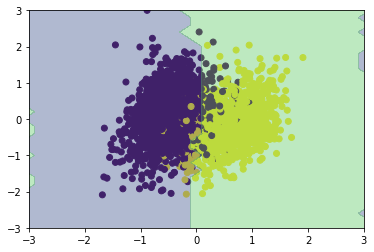

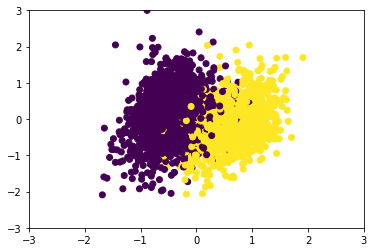

In [156]:
inspect_classification_boundaries(
    variational_classifier_linear, 
    params,
    plot_range=plot_range,
    train_coordinates=train_coordinates,
    train_labels=train_labels,
    grid_size=30,
)    

plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
plt.xlim(-plot_range,plot_range)
plt.ylim(-plot_range,plot_range)
plt.show()

In [157]:
X_train = train_coordinates.reshape(-1, n_components)
X_test = test_coordinates.reshape(-1, n_components)
y_train = train_labels
y_test = test_labels

clf = svm.SVC()
clf.fit(X_train, y_train)
 
pred_classic = clf.predict(X_train)
print(confusion_matrix(y_true=train_labels, y_pred=pred_classic))
print(classification_report(y_true=train_labels, y_pred=pred_classic))

pred_classic = clf.predict(X_test)
print(confusion_matrix(y_true=test_labels, y_pred=pred_classic))
print(classification_report(y_true=test_labels, y_pred=pred_classic))

[[1621  107]
 [ 119 1201]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1728
           1       0.92      0.91      0.91      1320

    accuracy                           0.93      3048
   macro avg       0.92      0.92      0.92      3048
weighted avg       0.93      0.93      0.93      3048

[[385  67]
 [ 64 246]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       452
           1       0.79      0.79      0.79       310

    accuracy                           0.83       762
   macro avg       0.82      0.82      0.82       762
weighted avg       0.83      0.83      0.83       762



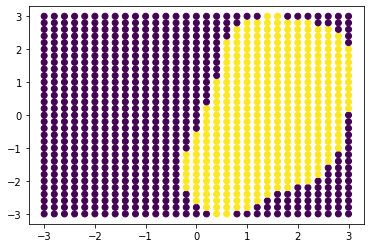

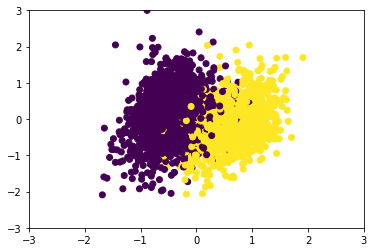

In [158]:
n_size = 30
grid_data = np.array([[2 * plot_range * j / n_size, 2 * plot_range * k / n_size] for j in range(-n_size // 2, n_size // 2 + 1, 1) for k in range(-n_size // 2, n_size // 2 + 1, 1)])
predictions = clf.predict(grid_data)
pred_labels = 1 * (np.array(predictions) > 0.5)

plt.scatter(x=grid_data[:,0], y=grid_data[:,1], c=pred_labels)
plt.show()

plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
plt.xlim(-plot_range,plot_range)
plt.ylim(-plot_range,plot_range)
plt.show()